In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Ignore harmless warnings
warnings.filterwarnings("ignore")


# --- Prints cortos de Bloque 0 (al final del bloque) ---
root = "/kaggle/input/nfl-big-data-bowl-2026-prediction"
train_dir = os.path.join(root, "train")

print(f"[B0] Dataset raíz: {root}")
print(f"[B0] Existe carpeta train: {os.path.exists(train_dir)}")
print(f"[B0] Archivos en raíz: {sorted(os.listdir(root))}")

# Cuenta inputs/outputs por semana para verificar integridad
inputs = sorted([f for f in os.listdir(train_dir) if f.startswith("input_2023_w")])
outputs = sorted([f for f in os.listdir(train_dir) if f.startswith("output_2023_w")])

print(f"[B0] Inputs pre-release (semanas): {len(inputs)}  | Outputs post-release (semanas): {len(outputs)}")
print("[B0] Listo: entorno cargado y archivos detectados.")

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [2]:
import cuml.accel

In [3]:

cuml.accel.install()

[2025-10-23 16:43:26.625] [CUML] [info] cuML: Installed accelerator for sklearn.


2025-10-23 16:43:39.873289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761237820.118557      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761237820.183074      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2025-10-23 16:43:59.063] [CUML] [info] cuML: Installed accelerator for umap.
[2025-10-23 16:43:59.145] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-10-23 16:43:59.145] [CUML] [info] cuML: Successfully initialized accelerator.


### Bloque 1 · Imports, configuración y utilidades básicas

In [4]:
# Imports estándar
import os
import gc
import math
import numpy as np
import pandas as pd

# Modelado y ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos base (puedes añadir más luego)
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optimización bayesiana con Optuna (si no está, puedes `pip install optuna` en Kaggle)
import optuna

# Semillas para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Constantes geométricas del campo
FIELD_X_MAX = 120.0
FIELD_Y_MAX = 53.3

# Función para convertir grados a radianes de forma segura
def deg2rad(angle_deg):
    return np.deg2rad(angle_deg % 360.0)

# Pequeño epsilon para evitar divisiones por cero
EPS = 1e-6


### Bloque 2 · Carga de datos (train input/output y test input)

In [5]:
# Define aquí tus rutas reales
DATA_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"
TEST_DIR = "/kaggle/input/nfl-big-data-bowl-2026-prediction"

# Ejemplo de carga por lotes de semanas; ajusta si ya los tienes concatenados
def load_train_inputs_outputs(data_dir):
    # Lista de archivos input y output
    inputs, outputs = [], []
    for w in range(1, 19):
        inp_path = os.path.join(data_dir, f"input_2023_w{w:02d}.csv")
        out_path = os.path.join(data_dir, f"output_2023_w{w:02d}.csv")
        if os.path.exists(inp_path):
            inputs.append(pd.read_csv(inp_path))
        if os.path.exists(out_path):
            outputs.append(pd.read_csv(out_path))
    # inp = pre-release (estado del juego antes del lanzamiento). Muchas filas, ~23 columnas con features crudas.
    # out = post-release (solo frames evaluados, solo jugador a predecir). Mucho menos filas, ~6 columnas con targets (x,y) y claves.
    inp = pd.concat(inputs, ignore_index=True)
    out = pd.concat(outputs, ignore_index=True)
    return inp, out

def load_test_input(test_dir):
    test_input_path = os.path.join(test_dir, "test_input.csv")
    return pd.read_csv(test_input_path)

# Carga (esto puede tardar según entorno)
inp_raw, out_raw = load_train_inputs_outputs(DATA_DIR)
test_inp_raw = load_test_input(TEST_DIR)

#4,880,579 (inp_raw) = todos los frames pre-release (10 Hz) de todos los 
#jugadores en todas las jugadas, incluidos los que no puntúan.

#562,936 (out_raw) = todos los frames post-release que sí hay que predecir 
#(solo jugadores player_to_predict y solo durante el vuelo de la bola).

print(f"[B2] {'pre-release (train)':<22} | filas: {inp_raw.shape[0]:>9,} | cols: {inp_raw.shape[1]:>2} | antes del release")
print(f"[B2] {'post-release (target)':<22} | filas: {out_raw.shape[0]:>9,} | cols: {out_raw.shape[1]:>2} | a predecir")
print(f"[B2] {'test pre-release':<22} | filas: {test_inp_raw.shape[0]:>9,} | cols: {test_inp_raw.shape[1]:>2} | test")



[B2] pre-release (train)    | filas: 4,880,579 | cols: 23 | antes del release
[B2] post-release (target)  | filas:   562,936 | cols:  6 | a predecir
[B2] test pre-release       | filas:    49,753 | cols: 23 | test


In [6]:
inp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

In [7]:
out_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562936 entries, 0 to 562935
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   game_id   562936 non-null  int64  
 1   play_id   562936 non-null  int64  
 2   nfl_id    562936 non-null  int64  
 3   frame_id  562936 non-null  int64  
 4   x         562936 non-null  float64
 5   y         562936 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 25.8 MB


### Bloque 2.5 · Filtro (Reducir inp_raw a claves evaluadas)

In [8]:
# Bloque 2.5 · Reducir inp_raw a claves evaluadas 

# Extrae las claves únicas (juego, jugada, jugador) que sí se evalúan (porque vienen de out_raw, que es el ground truth post-release).
# Hace un join interno entre todos los frames pre-release (inp_raw) y esa lista de claves (keys_eval).

# === Bloque 2.5 · Recortar inp_raw a claves evaluadas ===
keys_eval = out_raw[["game_id","play_id","nfl_id"]].drop_duplicates()

# Mantén solo los frames pre-release de esas claves
inp_raw = inp_raw.merge(keys_eval, on=["game_id","play_id","nfl_id"], how="inner")

print(f"[B2.5] inp_raw recortado      | filas: {inp_raw.shape[0]:>9,} | cols: {inp_raw.shape[1]:>2} | solo jugadores evaluados")


[B2.5] inp_raw recortado      | filas: 1,303,440 | cols: 23 | solo jugadores evaluados


In [9]:
inp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303440 entries, 0 to 1303439
Data columns (total 23 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1303440 non-null  int64  
 1   play_id                   1303440 non-null  int64  
 2   player_to_predict         1303440 non-null  bool   
 3   nfl_id                    1303440 non-null  int64  
 4   frame_id                  1303440 non-null  int64  
 5   play_direction            1303440 non-null  object 
 6   absolute_yardline_number  1303440 non-null  int64  
 7   player_name               1303440 non-null  object 
 8   player_height             1303440 non-null  object 
 9   player_weight             1303440 non-null  int64  
 10  player_birth_date         1303440 non-null  object 
 11  player_position           1303440 non-null  object 
 12  player_side               1303440 non-null  object 
 13  player_role               1

### Bloque 3 · Selección del “frame 0” (último pre-release por jugador/jugada)
Propósito: una sola fila por {game_id, play_id, nfl_id} con el último frame antes del pase.

te quedas solo con el último frame dentro del subconjunto de pre-release (el de frame_id máximo). Esa fila representa el estado inicial justo antes de que el balón salga (condiciones iniciales: x0, y0, s0, a0, o0, dir0) y se usa como base para predecir la trayectoria en el aire.

In [10]:
# === Bloque 3 · Frame 0 (último pre-release) ===
def get_frame0_fast(df_input):
    # índice del frame_id máximo por grupo (último pre-release)
    idx = df_input.groupby(["game_id","play_id","nfl_id"])["frame_id"].idxmax()
    f0 = df_input.loc[idx].copy()
    # renombra a sufijo 0 para claridad
    f0 = f0.rename(columns={"x":"x0","y":"y0","s":"s0","a":"a0","o":"o0","dir":"dir0"})
    return f0

f0 = get_frame0_fast(inp_raw)

# prints compactos
n_plays    = f0[["game_id","play_id"]].drop_duplicates().shape[0]
n_players  = f0["nfl_id"].nunique()
print(f"[B3]  f0 (frame 0)            | filas: {f0.shape[0]:>9,} | cols: {f0.shape[1]:>2} | 1 fila por jugador/jugada")
print(f"[B3]  jugadas únicas          | total: {n_plays:>10,}")
print(f"[B3]  jugadores únicos        | total: {n_players:>10,}")


[B3]  f0 (frame 0)            | filas:    46,045 | cols: 23 | 1 fila por jugador/jugada
[B3]  jugadas únicas          | total:     14,108
[B3]  jugadores únicos        | total:      1,178


### Bloque 4 · Normalización de dirección (todo a “ofensa hacia la derecha”)

Propósito: poner todo en el mismo eje (ofensa hacia la derecha) para que los patrones sean comparables.

In [11]:
# === Bloque 4 · Normalización izquierda→derecha ===
def normalize_inputs_direction(f0):
    df = f0.copy()
    mask_left = df["play_direction"].str.lower().eq("left")
    # reflejo en X e Y para x0/ball_land_x y y0/ball_land_y
    df.loc[mask_left, ["x0","ball_land_x"]] = FIELD_X_MAX - df.loc[mask_left, ["x0","ball_land_x"]]
    df.loc[mask_left, ["y0","ball_land_y"]] = FIELD_Y_MAX - df.loc[mask_left, ["y0","ball_land_y"]]
    # orientación/dirección: (180 - ángulo) mod 360
    df.loc[mask_left, ["o0","dir0"]] = (180.0 - df.loc[mask_left, ["o0","dir0"]]) % 360.0
    return df

def normalize_outputs_direction(out_df, f0_ref):
    # añade play_direction del input para usar la misma referencia
    ref = f0_ref[["game_id","play_id","nfl_id","play_direction"]]
    out = out_df.merge(ref, on=["game_id","play_id","nfl_id"], how="left")
    mask_left = out["play_direction"].str.lower().eq("left")
    out.loc[mask_left, "x"] = FIELD_X_MAX - out.loc[mask_left, "x"]
    out.loc[mask_left, "y"] = FIELD_Y_MAX - out.loc[mask_left, "y"]
    return out.drop(columns=["play_direction"])

# aplica normalización
f0_norm  = normalize_inputs_direction(f0)
out_norm = normalize_outputs_direction(out_raw, f0)

print(f"[B4]  f0_norm (input)         | filas: {f0_norm.shape[0]:>9,} | cols: {f0_norm.shape[1]:>2} | normalizado")
print(f"[B4]  out_norm (target)       | filas: {out_norm.shape[0]:>9,} | cols: {out_norm.shape[1]:>2} | normalizado")
print("[B4]  Nota: sistema común (ofensa→derecha).")


[B4]  f0_norm (input)         | filas:    46,045 | cols: 23 | normalizado
[B4]  out_norm (target)       | filas:   562,936 | cols:  6 | normalizado
[B4]  Nota: sistema común (ofensa→derecha).


### Bloque 4.5 · Filtrado player_to_predict==True + sincronización

Propósito: dejar solo los jugadores que puntúan y alinear los targets con esas claves.

In [12]:
# === Bloque 4.5 · Filtrar a ptp=True y sincronizar ===
# 1) frame 0: solo los que puntúan
f0_norm = f0_norm[f0_norm["player_to_predict"].astype(bool)].copy()

# 2) outputs: sincronizados solo a esas claves
out_norm = out_norm.merge(
    f0_norm[["game_id","play_id","nfl_id"]],
    on=["game_id","play_id","nfl_id"],
    how="inner"
)

print(f"[B4.5] f0_norm filtrado       | filas: {f0_norm.shape[0]:>9,} | cols: {f0_norm.shape[1]:>2} | ptp=True")
print(f"[B4.5] out_norm sync          | filas: {out_norm.shape[0]:>9,} | cols: {out_norm.shape[1]:>2} | frames evaluados")
print("[B4.5] Nota: trabajamos solo con los que puntúan; los targets conservan todos sus frames.")


[B4.5] f0_norm filtrado       | filas:    46,045 | cols: 23 | ptp=True
[B4.5] out_norm sync          | filas:   562,936 | cols:  6 | frames evaluados
[B4.5] Nota: trabajamos solo con los que puntúan; los targets conservan todos sus frames.


### ¿Qué unifiqué y por qué?

Mantuve los bloques separados (como quieres) pero:

En Bloque 3 usé idxmax() (más rápido que ordenar+tail).

En Bloque 4 dejé dos funciones (inputs/outputs) claras y vectorizadas.

Bloque 4.5 queda mínimo y directo (filtro + sync).

Eliminé líneas redundantes y una línea suelta que te podía romper el notebook.

Con esto, sigues tal cual al Bloque 4.9 (helpers) y Bloque 5★ (unificado) de ingeniería de características que te pasé antes. Si prefieres, también puedo “des-unificar” el 5★ (separar en 5, 5A y 6) pero mi recomendación es dejar 5★ porque allí ganó mucha robustez (evita duplicar make_features y previene el error de columnas duplicadas).

### Bloque 4.9 · Helpers (pequeñas utilidades)

In [13]:
# === Bloque 4.9 · Helpers de ingeniería de features (una sola vez) ===

def height_to_inches(h):
    # "6-2" -> 74; otros casos -> NaN
    try:
        if isinstance(h, str) and "-" in h:
            ft, inch = h.split("-")
            return int(ft)*12 + int(inch)
    except Exception:
        pass
    return np.nan

def wrap_angle(a):
    # Envuelve a [-pi, pi] para comparar ángulos sin discontinuidades
    return (a + np.pi) % (2*np.pi) - np.pi


### Bloque 5 · Construcción del dataset largo + features (UNIFICADO)

In [14]:
# === Bloque 5★ · train_long + features (unificado) ===
# Entrada esperada:
# - f0_norm: estado del último pre-release normalizado (una fila por {game_id, play_id, nfl_id})
# - out_norm: ground truth post-release normalizado (x,y por frame_id después del release)
# Salida:
# - train_df  : dataset listo para modelar (una fila por frame post-release)
# - NUM_COLS  : columnas numéricas de entrada
# - CAT_COLS  : columnas categóricas de entrada
# - Y_COLS    : targets ["dx_t","dy_t"]

FEATURE_FLAGS = {
    "ball_vector": True,   # dx_ball0, dy_ball0, dist_ball0, ang_to_ball0
    "angles":      True,   # o0_rad, dir0_rad, d_ang_o_ball, d_ang_dir_ball
    "velocity":    True,   # vx0, vy0
    "time_feats":  True,   # T, t, t_norm, s0_t, a0_t, dist_ball0_t
    "biometrics":  True,   # height_in, weight_lb
}

def build_training_table(f0_norm, out_norm, feature_flags=FEATURE_FLAGS):
    # 1) Une frame-0 (pre) con ground-truth (post) → tabla larga por frame t
    keep_f0 = [
        "game_id","play_id","nfl_id","player_to_predict",
        "player_side","player_role","player_position",
        "x0","y0","s0","a0","o0","dir0","absolute_yardline_number",
        "ball_land_x","ball_land_y","num_frames_output",
        "play_direction","player_height","player_weight","player_birth_date"
    ]
    base = f0_norm[keep_f0].copy()
    df   = out_norm.merge(base, on=["game_id","play_id","nfl_id"], how="left")

    # 2) Targets: desplazamientos relativos a frame-0
    df["dx_t"] = df["x"] - df["x0"]
    df["dy_t"] = df["y"] - df["y0"]

    # 3) Índices temporales del vuelo
    df["T"]      = df["num_frames_output"].clip(lower=1)
    df["t"]      = df["frame_id"].astype(int)
    df["t_norm"] = df["t"] / df["T"]

    # 4) Features base (siempre)
    num_cols = [
        "x0","y0","s0","a0","absolute_yardline_number",
        "ball_land_x","ball_land_y"
    ]
    cat_cols = ["player_side","player_role","player_position"]
    y_cols   = ["dx_t","dy_t"]

    # 5) Features opcionales por grupos
    if feature_flags.get("ball_vector", True):
        df["dx_ball0"] = df["ball_land_x"] - df["x0"]
        df["dy_ball0"] = df["ball_land_y"] - df["y0"]
        df["dist_ball0"] = np.hypot(df["dx_ball0"], df["dy_ball0"])
        # ángulo hacia el punto de caída (rad)
        df["ang_to_ball0"] = np.arctan2(df["dy_ball0"], df["dx_ball0"])
        num_cols += ["dx_ball0","dy_ball0","dist_ball0"]

    if feature_flags.get("angles", True):
        df["o0_rad"]   = deg2rad(df["o0"])
        df["dir0_rad"] = deg2rad(df["dir0"])
        # difs angulares envueltas a [-pi,pi]
        if "ang_to_ball0" not in df.columns:
            df["ang_to_ball0"] = np.arctan2(
                (df["ball_land_y"] - df["y0"]),
                (df["ball_land_x"] - df["x0"])
            )
        df["d_ang_o_ball"]   = wrap_angle(df["ang_to_ball0"] - df["o0_rad"])
        df["d_ang_dir_ball"] = wrap_angle(df["ang_to_ball0"] - df["dir0_rad"])
        num_cols += ["o0_rad","dir0_rad","d_ang_o_ball","d_ang_dir_ball"]

    if feature_flags.get("velocity", True):
        # componentes de velocidad inicial (cartesianas)
        if "dir0_rad" not in df.columns:
            df["dir0_rad"] = deg2rad(df["dir0"])
        df["vx0"] = df["s0"] * np.cos(df["dir0_rad"])
        df["vy0"] = df["s0"] * np.sin(df["dir0_rad"])
        num_cols += ["vx0","vy0"]

    if feature_flags.get("time_feats", True):
        df["s0_t"]        = df["s0"] * df["t_norm"]
        df["a0_t"]        = df["a0"] * df["t_norm"]
        if "dist_ball0" in df.columns:
            df["dist_ball0_t"] = df["dist_ball0"] * df["t_norm"]
            num_cols += ["T","t","t_norm","s0_t","a0_t","dist_ball0_t"]
        else:
            num_cols += ["T","t","t_norm","s0_t","a0_t"]

    if feature_flags.get("biometrics", True):
        df["height_in"] = df["player_height"].apply(height_to_inches)
        df["weight_lb"] = pd.to_numeric(df["player_weight"], errors="coerce")
        num_cols += ["height_in","weight_lb"]

    # 6) Ensamble de salida
    #    - quitamos filas con NaN en los targets por seguridad
    df_model = df.dropna(subset=y_cols).copy()

    # Comprobaciones defensivas
    #   1) columnas únicas
    assert pd.Index(num_cols + cat_cols + y_cols).is_unique, "Columnas de entrada/target no son únicas"
    #   2) todas existen
    missing = [c for c in (num_cols + cat_cols + y_cols) if c not in df_model.columns]
    assert not missing, f"Faltan columnas en df_model: {missing}"
    #   3) bandera de filtrado
    assert df_model["player_to_predict"].all(), "Hay filas con player_to_predict != True"

    return df_model, num_cols, cat_cols, y_cols

# === Ejecutar construcción ===
train_df, NUM_COLS, CAT_COLS, Y_COLS = build_training_table(f0_norm, out_norm)

# Prints mínimos y claros
print(f"[B5] train_df (listo para modelar) | filas: {train_df.shape[0]:>9,} | cols: {train_df.shape[1]:>2}")
print(f"[B5] NUM_COLS: {len(NUM_COLS)} | CAT_COLS: {len(CAT_COLS)} | Y_COLS: {Y_COLS}")


[B5] train_df (listo para modelar) | filas:   562,936 | cols: 44
[B5] NUM_COLS: 24 | CAT_COLS: 3 | Y_COLS: ['dx_t', 'dy_t']


## === Bloque 6.5 · EDA visual PRO ===


[B6.5] train_df: (562936, 44)  |  NUM_COLS=24  CAT_COLS=3  Y_COLS=2
[B6.5] .info() columnas del modelo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562936 entries, 0 to 562935
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   x0                        562936 non-null  float64
 1   y0                        562936 non-null  float64
 2   s0                        562936 non-null  float64
 3   a0                        562936 non-null  float64
 4   absolute_yardline_number  562936 non-null  int64  
 5   ball_land_x               562936 non-null  float64
 6   ball_land_y               562936 non-null  float64
 7   dx_ball0                  562936 non-null  float64
 8   dy_ball0                  562936 non-null  float64
 9   dist_ball0                562936 non-null  float64
 10  o0_rad                    562936 non-null  float64
 11  dir0_rad                  562936 non-null  float64
 

,count,missing,missing_pct,unique,mean,std,min,p01,p05,p50,p95,p99,max,skew
x0,562936.000000,0.000000,0.00%,11392,67.021,22.992,7.440,23.650,33.690,64.520,108.120,113.370,119.390,0.250
y0,562936.000000,0.000000,0.00%,7468,26.491,11.788,0.690,4.890,8.350,26.300,44.910,48.360,52.620,0.022
s0,562936.000000,0.000000,0.00%,988,4.812,2.052,0.000,0.610,1.430,4.770,8.200,9.110,10.340,0.030
a0,562936.000000,0.000000,0.00%,782,2.732,1.466,0.000,0.280,0.650,2.550,5.380,6.390,8.360,0.496
absolute_yardline_number,562936.000000,0.000000,0.00%,99,60.359,23.100,11.000,14.000,24.000,60.000,98.000,106.000,109.000,0.019
ball_land_x,562936.000000,0.000000,0.00%,8864,71.687,24.808,7.800,23.190,34.800,69.860,113.560,118.070,125.850,0.134
ball_land_y,562936.000000,0.000000,0.00%,7869,26.506,16.508,-4.030,-0.220,2.440,26.150,50.880,53.480,57.210,0.021
dx_ball0,562936.000000,0.000000,0.00%,39350,4.666,9.324,-21.100,-10.370,-7.310,1.990,23.490,29.930,41.590,0.853
dy_ball0,562936.000000,0.000000,0.00%,41694,0.014,9.244,-33.300,-21.880,-14.850,-0.000,15.190,21.820,49.680,0.015
dist_ball0,562936.000000,0.000000,0.00%,46045,11.779,7.444,0.022,0.960,2.599,9.762,26.707,32.702,49.740,0.946


[B6.5] Top-10 categorías por variable categórica:


,count,pct
player_side,,
Defense,402576,71.51%
Offense,160360,28.49%


,count,pct
player_role,,
Defensive Coverage,402576,71.51%
Targeted Receiver,160360,28.49%


,count,pct
player_position,,
CB,172674,30.67%
WR,108067,19.20%
FS,71862,12.77%
SS,56876,10.10%
ILB,40009,7.11%
TE,32195,5.72%
OLB,28316,5.03%
MLB,27721,4.92%
RB,18681,3.32%


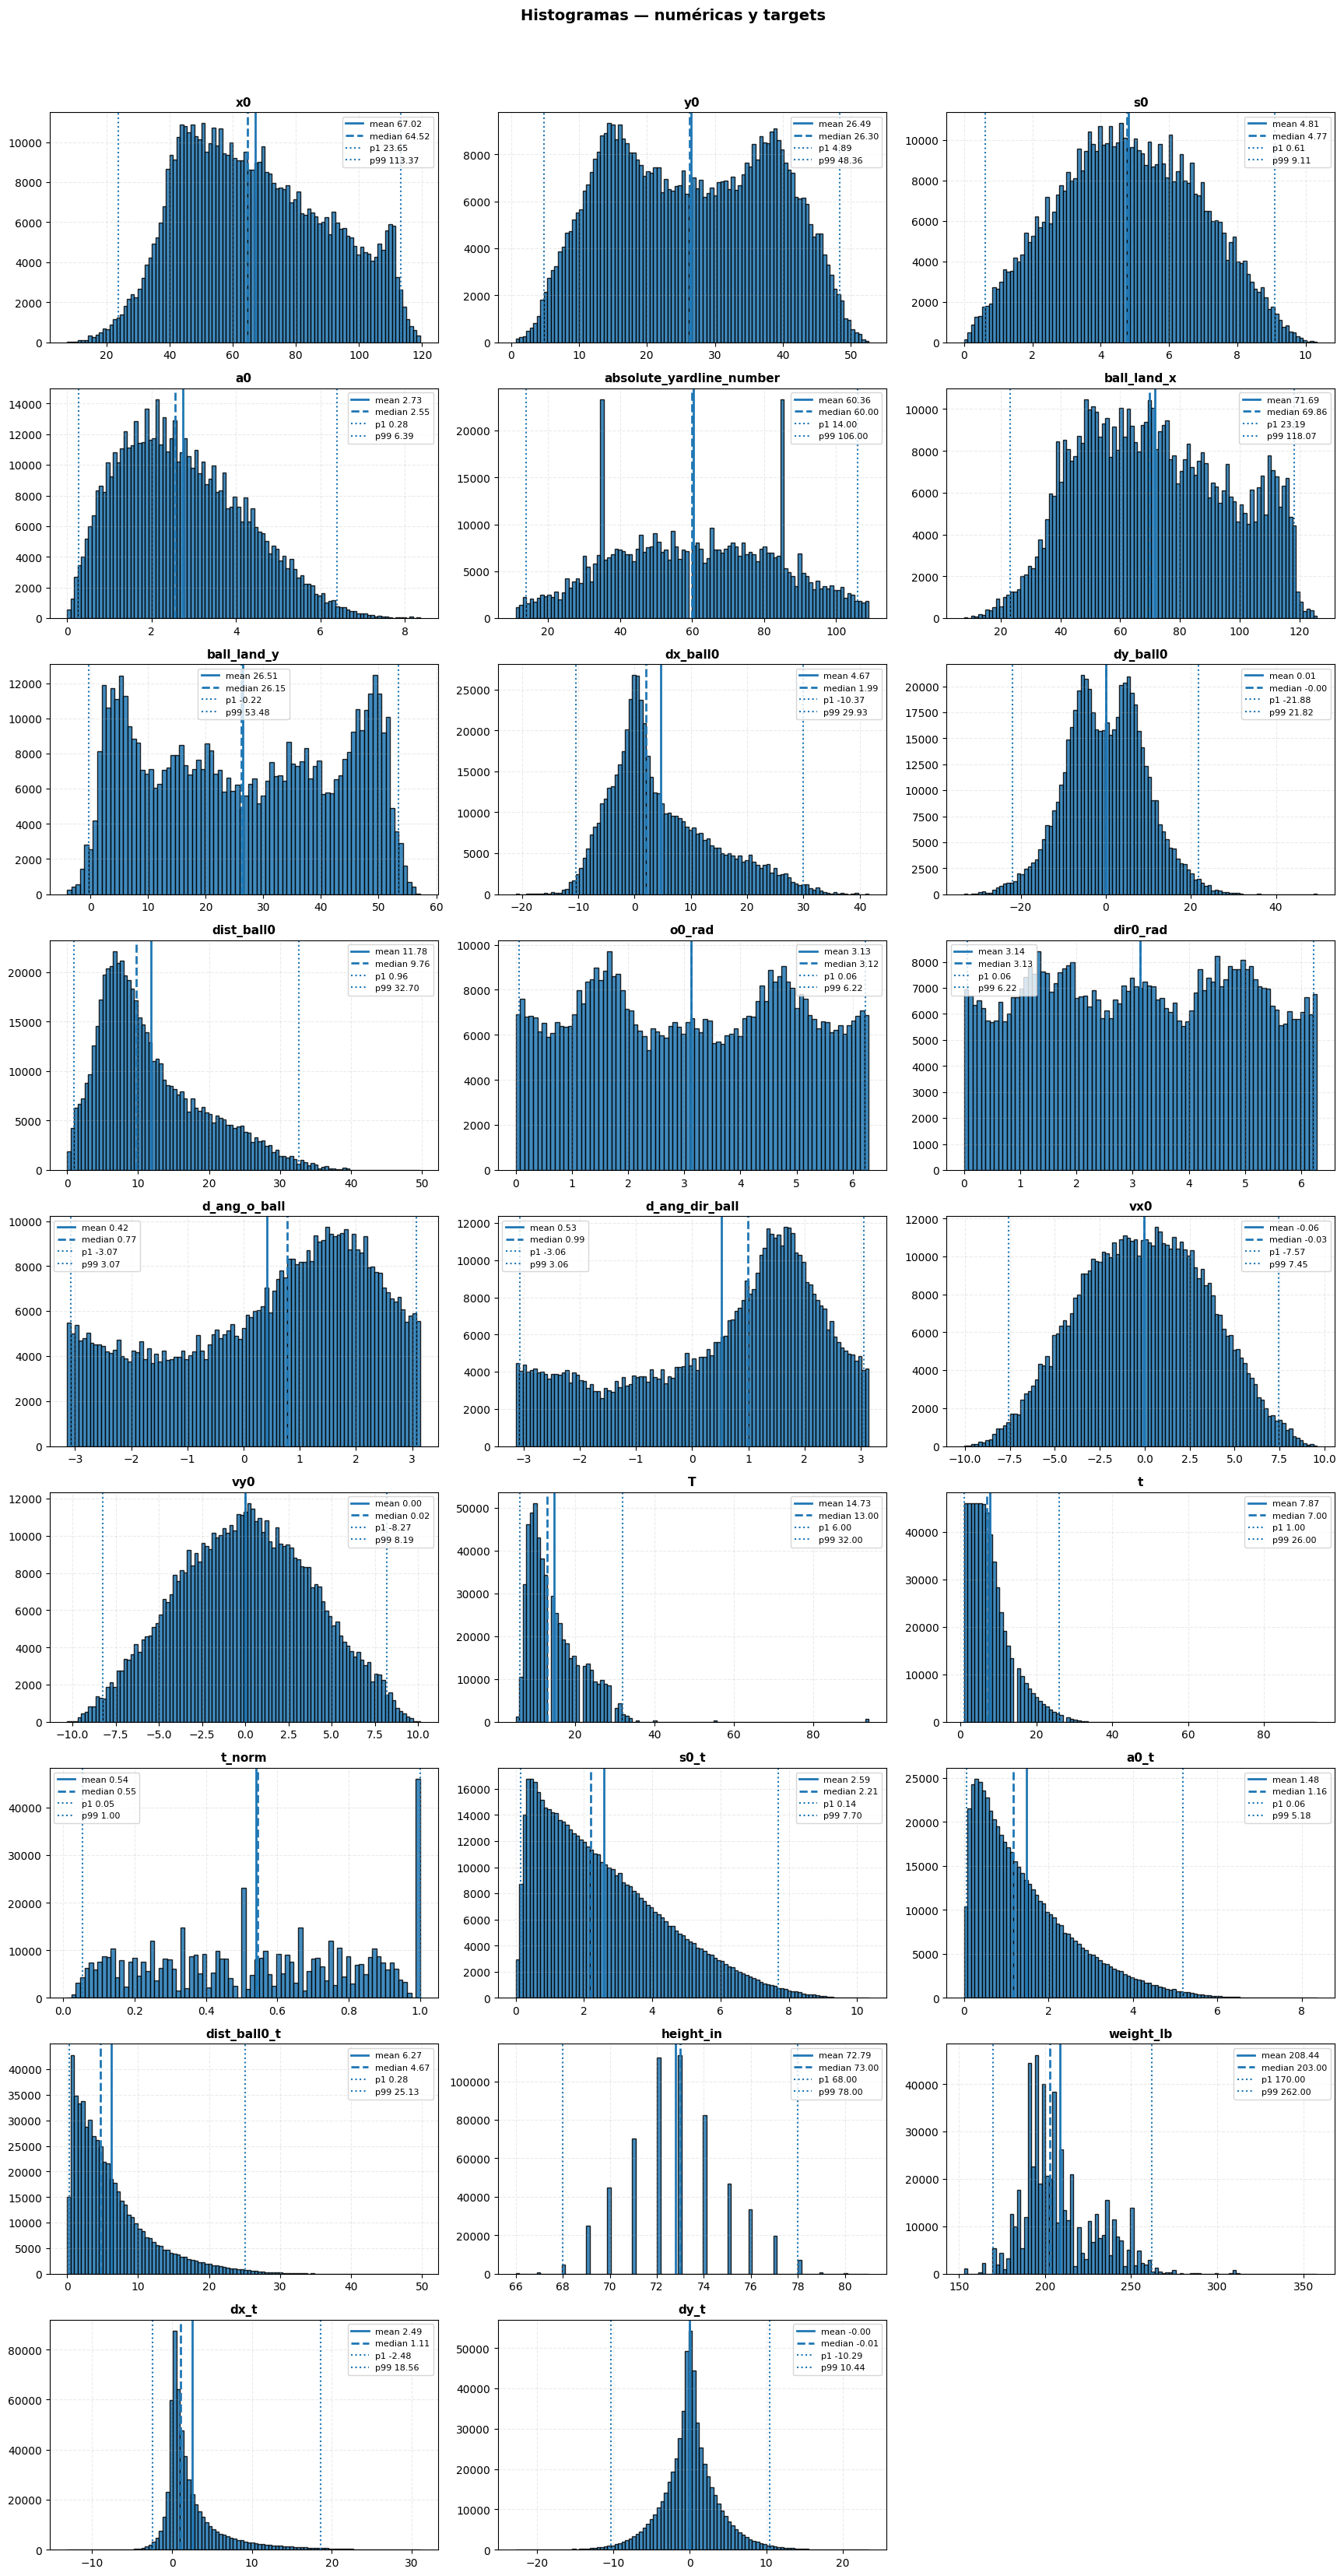

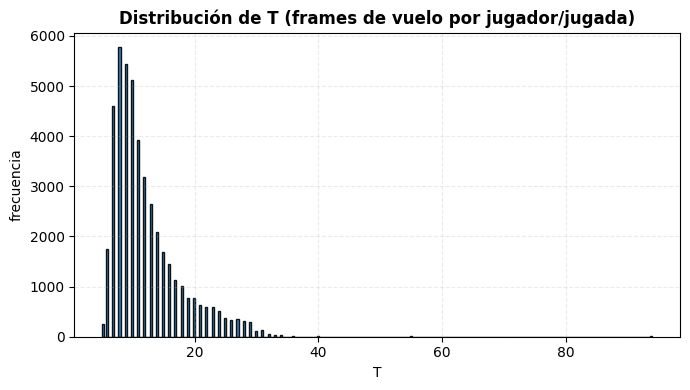

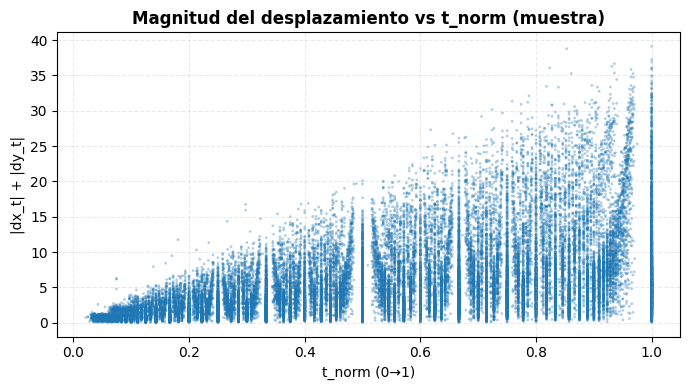

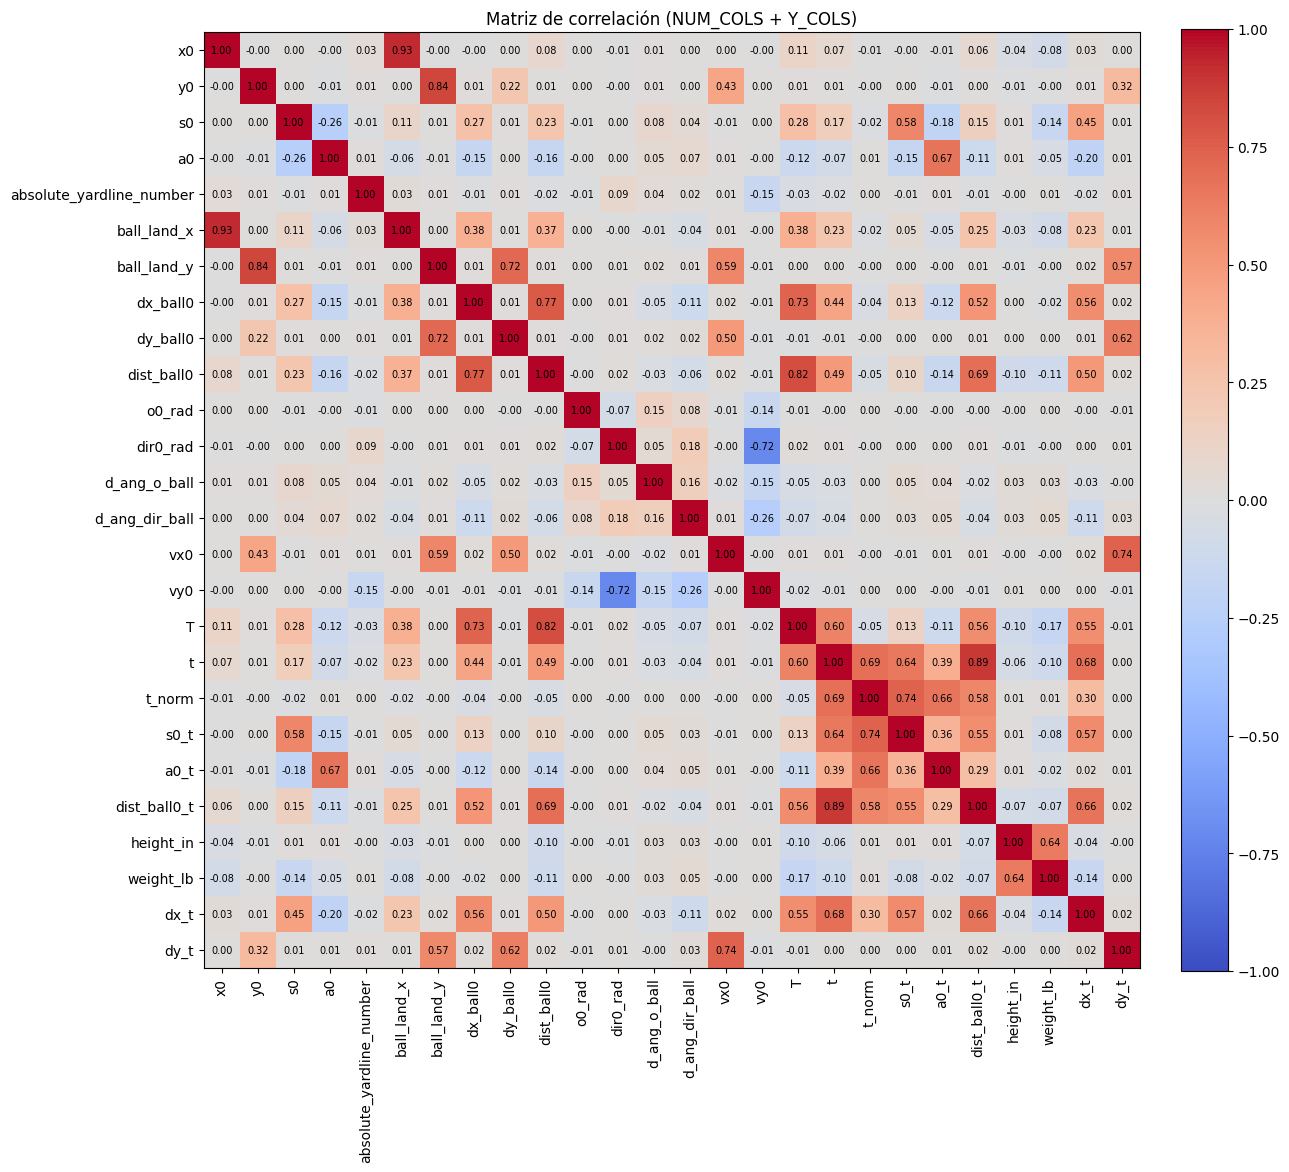

[B6.5] EDA completado (solo con train_df).


In [15]:
# === Bloque 6.5 · EDA visual PRO (solo con train_df) ===
# Requiere en memoria: train_df, NUM_COLS, CAT_COLS, Y_COLS, RANDOM_STATE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

print(f"[B6.5] train_df: {train_df.shape}  |  NUM_COLS={len(NUM_COLS)}  CAT_COLS={len(CAT_COLS)}  Y_COLS={len(Y_COLS)}")

# --- 1) info() compacto ---
buf = StringIO()
train_df[NUM_COLS + CAT_COLS + Y_COLS].info(buf=buf)
print("[B6.5] .info() columnas del modelo:")
print(buf.getvalue())

# --- 2) describe numérico enriquecido (NUM_COLS + Y_COLS) ---
def numeric_summary(df, cols):
    d = df[cols].apply(pd.to_numeric, errors='coerce')
    desc = d.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T
    desc['missing'] = d.shape[0] - desc['count']
    desc['missing_pct'] = 100 * desc['missing'] / d.shape[0]
    desc['unique'] = d.nunique(dropna=True)
    desc['skew']   = d.skew(numeric_only=True)
    return desc.rename(columns={'1%':'p01','5%':'p05','50%':'p50','95%':'p95','99%':'p99'})[
        ['count','missing','missing_pct','unique','mean','std','min','p01','p05','p50','p95','p99','max','skew']
    ].round(3)

num_desc = numeric_summary(train_df, NUM_COLS + Y_COLS)
display(
    num_desc.style
    .format({'missing_pct': "{:.2f}%", 'mean': "{:.3f}", 'std': "{:.3f}",
             'min': "{:.3f}", 'p01': "{:.3f}", 'p05': "{:.3f}", 'p50': "{:.3f}",
             'p95': "{:.3f}", 'p99': "{:.3f}", 'max': "{:.3f}", 'skew': "{:.3f}"})
    .bar(subset=['missing_pct'], color='#f5b7b1')
    .background_gradient(subset=['mean','std','skew'], cmap='Blues')
    .set_caption("Resumen numérico (NUM_COLS + Y_COLS)")
)

# --- 3) Top-10 categorías ---
print("[B6.5] Top-10 categorías por variable categórica:")
for c in CAT_COLS:
    vc = (train_df[c].fillna("NA").value_counts(dropna=False).head(10).rename("count").to_frame())
    vc['pct'] = (vc['count'] / len(train_df) * 100).round(2)
    display(vc.style.format({'pct':'{:.2f}%'}).bar(subset=['count'], color='#aed6f1').set_caption(f"Top-10 — {c}"))

# --- 4) Histogramas (NUM_COLS + Y_COLS) en grilla 3xN ---
def fd_bins(x):
    x = np.asarray(x); x = x[np.isfinite(x)]
    if x.size < 2: return 10
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    if iqr == 0: return min(50, max(10, int(np.sqrt(x.size))))
    bw = 2 * iqr * x.size ** (-1/3)
    if bw <= 0: return min(50, max(10, int(np.sqrt(x.size))))
    return int(np.clip((x.max() - x.min()) / bw, 10, 100))

grid_cols = 3   # cambia a 2 si prefieres dos columnas
plot_cols = NUM_COLS + Y_COLS
n = len(plot_cols)
rows = int(np.ceil(n / grid_cols))

fig, axes = plt.subplots(rows, grid_cols, figsize=(grid_cols*5.8, rows*3.6))
axes = np.array(axes).reshape(rows, grid_cols)

for i, col in enumerate(plot_cols):
    r, c = divmod(i, grid_cols); ax = axes[r, c]
    x = pd.to_numeric(train_df[col], errors='coerce').dropna().values
    if x.size == 0:
        ax.set_visible(False); continue
    bins = fd_bins(x)
    ax.hist(x, bins=bins, edgecolor='black', alpha=0.85)
    ax.grid(alpha=0.25, linestyle='--')
    ax.set_title(col, fontsize=11, fontweight='bold')
    mean, med = np.mean(x), np.median(x)
    p01, p99 = np.percentile(x, [1, 99])
    ax.axvline(mean, linewidth=2, label=f"mean {mean:.2f}")
    ax.axvline(med, linestyle='--', linewidth=2, label=f"median {med:.2f}")
    ax.axvline(p01, linestyle=':', linewidth=1.5, label=f"p1 {p01:.2f}")
    ax.axvline(p99, linestyle=':', linewidth=1.5, label=f"p99 {p99:.2f}")
    ax.legend(fontsize=8, frameon=True)

# apaga ejes sobrantes si los hay
for j in range(i+1, rows*grid_cols):
    r, c = divmod(j, grid_cols); axes[r, c].axis("off")

plt.suptitle("Histogramas — numéricas y targets", y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 5) Distribución de T (frames de vuelo por jugador/jugada) desde train_df ---
# train_df ya tiene T; usamos el máximo T por {game_id, play_id, nfl_id}
T_series = (train_df[["game_id","play_id","nfl_id","T"]]
            .drop_duplicates()
            .groupby(["game_id","play_id","nfl_id"])["T"]
            .max())
plt.figure(figsize=(7,4))
plt.hist(T_series.values, bins='auto', edgecolor='black', alpha=0.9)
plt.grid(alpha=0.25, linestyle='--')
plt.title("Distribución de T (frames de vuelo por jugador/jugada)", fontsize=12, fontweight='bold')
plt.xlabel("T"); plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

# --- 6) Relación t_norm vs |Δ| (muestra) ---
sample = train_df.sample(min(50_000, len(train_df)), random_state=RANDOM_STATE)
disp_mag = sample["dx_t"].abs() + sample["dy_t"].abs()
plt.figure(figsize=(7,4))
plt.scatter(sample["t_norm"].values, disp_mag.values, s=4, alpha=0.35, edgecolors='none')
plt.grid(alpha=0.25, linestyle='--')
plt.title("Magnitud del desplazamiento vs t_norm (muestra)", fontsize=12, fontweight='bold')
plt.xlabel("t_norm (0→1)"); plt.ylabel("|dx_t| + |dy_t|")
plt.tight_layout()
plt.show()

# --- 7) Matriz de correlación (NUM_COLS + Y_COLS) ---
corr_cols = NUM_COLS + Y_COLS
corr = train_df[corr_cols].corr()
plt.figure(figsize=(max(8, 0.5*len(corr_cols)), max(6, 0.5*len(corr_cols))))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(corr_cols)), labels=corr_cols, rotation=90)
plt.yticks(ticks=np.arange(len(corr_cols)), labels=corr_cols)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=7)
plt.title("Matriz de correlación (NUM_COLS + Y_COLS)")
plt.tight_layout()
plt.show()

print("[B6.5] EDA completado (solo con train_df).")
# === fin Bloque 6.5 ===


### Bloque 7 · Split 60/20/20 por jugada (sin fuga de información)

In [16]:
# Split por {game_id, play_id} para que una jugada no aparezca en varios conjuntos
def split_by_play(df, test_size_eval=0.2, test_size_valid=0.2, random_state=RANDOM_STATE):
    # Obtiene únicas jugadas
    plays = df[["game_id","play_id"]].drop_duplicates().copy()

    # Primero separación evaluation (20%)
    plays_train_valid, plays_eval = train_test_split(
        plays,
        test_size=test_size_eval,
        random_state=random_state,
        shuffle=True
    )

    # Luego dentro del train_valid, saca validación (20% de todo → 25% de este subconjunto)
    plays_train, plays_valid = train_test_split(
        plays_train_valid,
        test_size=test_size_valid / (1 - test_size_eval),
        random_state=random_state,
        shuffle=True
    )

    def subset(p):
        return df.merge(p, on=["game_id","play_id"], how="inner")

    train = subset(plays_train)
    valid = subset(plays_valid)
    eval_ = subset(plays_eval)

    return train, valid, eval_

train_set, valid_set, eval_set = split_by_play(train_df)
train_set.shape, valid_set.shape, eval_set.shape

print("train:", train_set.shape, "valid:", valid_set.shape, "eval:", eval_set.shape)


train: (337582, 44) valid: (110826, 44) eval: (114528, 44)


### Chequeo de partición 60/20/20 por jugada y fugas

In [17]:
# === Chequeo de partición 60/20/20 por jugada y fugas ===
def _n_plays(df): 
    return df[["game_id","play_id"]].drop_duplicates().shape[0]

tot_plays = _n_plays(train_df)
tr_plays  = _n_plays(train_set)
va_plays  = _n_plays(valid_set)
ev_plays  = _n_plays(eval_set)

def _pct(a, b): 
    return 100.0 * a / b if b else 0.0

print(f"[B7] Jugadas totales         : {tot_plays:>7,}")
print(f"[B7] Train (plays)           : {tr_plays:>7,}  ({_pct(tr_plays, tot_plays):5.1f}%)  ~60%")
print(f"[B7] Valid (plays)           : {va_plays:>7,}  ({_pct(va_plays, tot_plays):5.1f}%)  ~20%")
print(f"[B7] Eval  (plays)           : {ev_plays:>7,}  ({_pct(ev_plays, tot_plays):5.1f}%)  ~20%")

# También por filas (frames), solo informativo
tot_rows = len(train_df); tr_rows = len(train_set); va_rows = len(valid_set); ev_rows = len(eval_set)
print(f"[B7] Train (filas)           : {tr_rows:>7,}  ({_pct(tr_rows, tot_rows):5.1f}%)")
print(f"[B7] Valid (filas)           : {va_rows:>7,}  ({_pct(va_rows, tot_rows):5.1f}%)")
print(f"[B7] Eval  (filas)           : {ev_rows:>7,}  ({_pct(ev_rows, tot_rows):5.1f}%)")
print(f"[B7] Suma filas = total      : {tr_rows + va_rows + ev_rows == tot_rows}")

# Comprobación de fugas: una jugada no debe aparecer en varios sets
tr_keys = set(map(tuple, train_set[["game_id","play_id"]].drop_duplicates().values))
va_keys = set(map(tuple, valid_set[["game_id","play_id"]].drop_duplicates().values))
ev_keys = set(map(tuple, eval_set[["game_id","play_id"]].drop_duplicates().values))

leak_tv = tr_keys & va_keys
leak_te = tr_keys & ev_keys
leak_ve = va_keys & ev_keys

assert len(leak_tv) == 0 and len(leak_te) == 0 and len(leak_ve) == 0, "¡Fuga detectada entre splits!"
print("[B7] Sin fugas por jugada (train/valid/eval son disjuntos).")


[B7] Jugadas totales         :  14,108
[B7] Train (plays)           :   8,464  ( 60.0%)  ~60%
[B7] Valid (plays)           :   2,822  ( 20.0%)  ~20%
[B7] Eval  (plays)           :   2,822  ( 20.0%)  ~20%
[B7] Train (filas)           : 337,582  ( 60.0%)
[B7] Valid (filas)           : 110,826  ( 19.7%)
[B7] Eval  (filas)           : 114,528  ( 20.3%)
[B7] Suma filas = total      : True
[B7] Sin fugas por jugada (train/valid/eval son disjuntos).


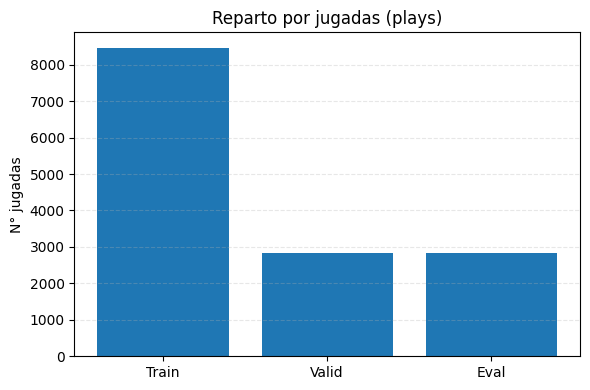

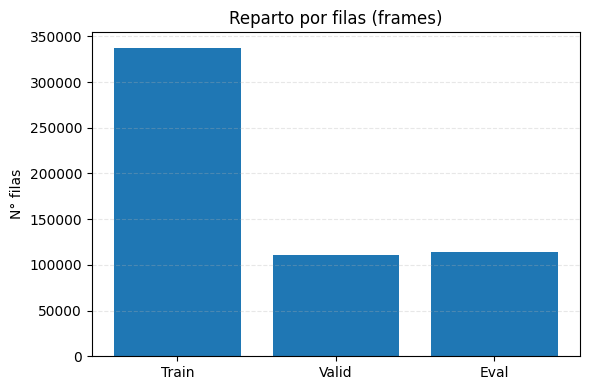

In [18]:
# Mini visual de la partición por plays y por filas
import matplotlib.pyplot as plt

# Datos
plays_counts = [tr_plays, va_plays, ev_plays]
rows_counts  = [tr_rows,  va_rows,  ev_rows]
labels = ["Train", "Valid", "Eval"]

# Barras por plays
plt.figure(figsize=(6,4))
plt.bar(labels, plays_counts)
plt.title("Reparto por jugadas (plays)")
plt.ylabel("N° jugadas")
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Barras por filas
plt.figure(figsize=(6,4))
plt.bar(labels, rows_counts)
plt.title("Reparto por filas (frames)")
plt.ylabel("N° filas")
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


### Bloque 8 · Preprocesamiento, matrices y métricas 

In [19]:
# === Bloque 8 · Preprocesamiento, matrices y métricas ===
# Requiere: train_set, valid_set, eval_set, NUM_COLS, CAT_COLS, Y_COLS, RANDOM_STATE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Preproceso: escala numéricas y One-Hot a categóricas
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), NUM_COLS),       #reescala los datos para tener una media de 0 y una desviación estándar de 1
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), CAT_COLS) #Crea una columna binaria (0/1) por cada categoría.
    ],
    remainder="drop"
)

# Matrices (solo columnas del modelo)
FEATURES_FOR_MODEL = NUM_COLS + CAT_COLS
assert len(FEATURES_FOR_MODEL) == len(set(FEATURES_FOR_MODEL)), "Columnas repetidas en FEATURES_FOR_MODEL"

X_train = train_set[FEATURES_FOR_MODEL].copy()
y_train = train_set[Y_COLS].values           # [dx_t, dy_t]
X_valid = valid_set[FEATURES_FOR_MODEL].copy()
y_valid = valid_set[Y_COLS].values
X_eval  = eval_set[FEATURES_FOR_MODEL].copy()
y_eval  = eval_set[Y_COLS].values

# Métricas (MAE, MSE, R2, MAPE) + RMSE combinado para tuning
EPS = 1e-6  # evita división por cero en MAPE

def compute_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred, multioutput="uniform_average")
    mse  = mean_squared_error(y_true, y_pred, multioutput="uniform_average")
    r2   = r2_score(y_true, y_pred, multioutput="uniform_average")
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), EPS, None)))
    return {"MAE": mae, "MSE": mse, "R2": r2, "MAPE": mape}

def rmse_2d(y_true, y_pred):
    # RMSE único promediando dx y dy (objetivo para Optuna)
    return np.sqrt(mean_squared_error(y_true, y_pred, multioutput="uniform_average"))

print(f"[B8] X_train={X_train.shape}  X_valid={X_valid.shape}  X_eval={X_eval.shape}")
print("[B8] Preprocesamiento y métricas listos.")


[B8] X_train=(337582, 27)  X_valid=(110826, 27)  X_eval=(114528, 27)
[B8] Preprocesamiento y métricas listos.


In [20]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Bloque 9 · Catálogo de modelos + espacios de hiperparámetros (con justificación breve)

In [21]:
# === Bloque 9 · Catálogo de modelos y espacios de hiperparámetros (Optuna) ===
# Requiere: preprocess, rmse_2d, RANDOM_STATE, X_train/X_valid/y_train/y_valid

import optuna

# Intentar activar XGB si está disponible (opcional en punto 2)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("[B9] XGBoost no disponible:", e)

# Modelos pedidos en el punto 2 (sin kernels por costo)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ——— MODELOS CON KERNEL (defínelos si quieres probar; alto costo de RAM/tiempo) ———
# from sklearn.kernel_ridge import KernelRidge              # Kernel Ridge
# from sklearn.svm import SVR                               # Support Vector Regression
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# -----------------------------------------------------------------------------------

# Presupuesto de búsqueda
N_TRIALS_DEFAULT = 20       # súbelo si quieres afinar más
MAX_TUNE_ROWS    = 150_000  # submuestrea train para acelerar el tuning

def make_estimator(name, trial):
    """
    Devuelve un estimador base (sin MultiOutput). 
    *Justificación breve de cada espacio en comentarios.*
    """
    # — Baselines lineales —
    if name == "LinearRegression":
        # Baseline sin hiperparámetros
        return LinearRegression()

    if name == "Ridge":
        # L2 controla magnitud de w (evita sobreajuste)
        alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)
        return Ridge(alpha=alpha, random_state=RANDOM_STATE)

    if name == "Lasso":
        # L1 induce esparsidad / selección de variables
        alpha = trial.suggest_float("alpha", 1e-6, 10.0, log=True)
        return Lasso(alpha=alpha, random_state=RANDOM_STATE, max_iter=20000)

    if name == "ElasticNet":
        # Mezcla L1/L2; l1_ratio regula el balance
        alpha = trial.suggest_float("alpha", 1e-6, 10.0, log=True)
        l1r   = trial.suggest_float("l1_ratio", 0.0, 1.0)
        return ElasticNet(alpha=alpha, l1_ratio=l1r, random_state=RANDOM_STATE, max_iter=20000)

    if name == "SGDRegressor":
        # Escalable; Huber (robusta) + regularización
        alpha = trial.suggest_float("alpha", 1e-6, 1e-1, log=True)
        l1r   = trial.suggest_float("l1_ratio", 0.0, 1.0)
        eps   = trial.suggest_float("epsilon", 1e-4, 1.0, log=True)
        return SGDRegressor(loss="huber", alpha=alpha, l1_ratio=l1r, epsilon=eps,
                            random_state=RANDOM_STATE, max_iter=2000, tol=1e-3)

    if name == "BayesianRidge":
        # Priors Gamma sobre precisiones → suavizado bayesiano
        alpha_1  = trial.suggest_float("alpha_1", 1e-8, 1e-2, log=True)
        alpha_2  = trial.suggest_float("alpha_2", 1e-8, 1e-2, log=True)
        lambda_1 = trial.suggest_float("lambda_1", 1e-8, 1e-2, log=True)
        lambda_2 = trial.suggest_float("lambda_2", 1e-8, 1e-2, log=True)
        return BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2,
                             lambda_1=lambda_1, lambda_2=lambda_2)

    # — No lineales (árboles/boosting) —
    if name == "RandomForestRegressor":
        # Control de varianza/profundidad + suavizado en hojas
        n_estimators     = trial.suggest_int("n_estimators", 200, 800)
        max_depth        = trial.suggest_int("max_depth", 6, 28)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
        return RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=RANDOM_STATE
        )

    if name == "GradientBoostingRegressor":
        # Nº etapas, lr, profundidad y subsample (regularización)
        n_estimators = trial.suggest_int("n_estimators", 100, 800)
        lr           = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_depth    = trial.suggest_int("max_depth", 2, 6)
        subsample    = trial.suggest_float("subsample", 0.6, 1.0)
        return GradientBoostingRegressor(
            n_estimators=n_estimators, learning_rate=lr, max_depth=max_depth,
            subsample=subsample, random_state=RANDOM_STATE
        )

    if name == "XGBRegressor" and HAS_XGB:
        # Espacio razonable para tabular one-hot; wrapper MultiOutput va en Bloque 10
        n_estimators = trial.suggest_int("n_estimators", 300, 1200)
        lr          = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        max_depth   = trial.suggest_int("max_depth", 3, 9)
        subsample   = trial.suggest_float("subsample", 0.6, 1.0)
        colsample   = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        reg_alpha   = trial.suggest_float("reg_alpha", 0.0, 1.0)
        reg_lambda  = trial.suggest_float("reg_lambda", 0.0, 2.0)
        return XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=lr,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            objective="reg:squarederror",
            tree_method="hist",   # si tienes GPU: "gpu_hist"
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    # — (Opcionales con kernel: comentar/descomentar bajo recursos) —
    # if name == "KernelRidge":
    #     kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
    #     alpha  = trial.suggest_float("alpha", 1e-5, 1e1, log=True)
    #     if kernel == "rbf":
    #         gamma = trial.suggest_float("gamma", 1e-5, 1e1, log=True)
    #         return KernelRidge(kernel="rbf", alpha=alpha, gamma=gamma)
    #     else:
    #         degree = trial.suggest_int("degree", 2, 5)
    #         coef0  = trial.suggest_float("coef0", 0.0, 1.0)
    #         return KernelRidge(kernel="poly", alpha=alpha, degree=degree, coef0=coef0)

    # if name == "SVR":
    #     C = trial.suggest_float("C", 1e-1, 1e3, log=True)
    #     eps = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
    #     kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
    #     if kernel == "rbf":
    #         gamma = trial.suggest_float("gamma", 1e-5, 1e0, log=True)
    #         base = SVR(kernel="rbf", C=C, epsilon=eps, gamma=gamma)
    #     else:
    #         degree = trial.suggest_int("degree", 2, 4)
    #         base = SVR(kernel="poly", C=C, epsilon=eps, degree=degree)
    #     # Envolver en MultiOutput en Bloque 10 (dos SVR)
    #     return base

    # if name == "GaussianProcessRegressor":
    #     length = trial.suggest_float("length_scale", 0.1, 10.0, log=True)
    #     noise  = trial.suggest_float("noise", 1e-6, 1e-1, log=True)
    #     kernel = RBF(length) + WhiteKernel(noise_level=noise)
    #     base = GaussianProcessRegressor(kernel=kernel, alpha=noise, normalize_y=True, random_state=RANDOM_STATE)
    #     return base

    raise ValueError(f"Modelo no soportado: {name}")

MODEL_LIST = [
    "LinearRegression",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "SGDRegressor",
    "BayesianRidge",
    #"RandomForestRegressor",
    #"GradientBoostingRegressor",
    # "KernelRidge",              # (kernel)
    # "SVR",                      # (kernel)
    # "GaussianProcessRegressor", # (kernel, O(N^3))
]

# Añade XGB si está disponible
if HAS_XGB:
    MODEL_LIST.append("XGBRegressor")


In [22]:
print("[B9] Modelos a tunear:", MODEL_LIST)
if not HAS_XGB:
    print("[B9] (XGB no se incluirá porque no está disponible en este entorno)")


[B9] Modelos a tunear: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SGDRegressor', 'BayesianRidge', 'XGBRegressor']


### Bloque 10 · Optimización bayesiana por modelo (usa valid_set como criterio)

In [23]:
# 1) sampler con seed para reproducibilidad
import optuna
from optuna.samplers import TPESampler

def tune_model(model_name, n_trials=N_TRIALS_DEFAULT, max_rows=MAX_TUNE_ROWS):
    # submuestreo para tuning
    if len(X_train) > max_rows:
        rng = np.random.RandomState(RANDOM_STATE)
        sub_idx = rng.choice(len(X_train), size=max_rows, replace=False)
        Xtr = X_train.iloc[sub_idx].copy()
        ytr = y_train[sub_idx].copy()
    else:
        Xtr, ytr = X_train, y_train

    def objective(trial):
        est = make_estimator(model_name, trial)
        # si el estimador ya viene envuelto (SVR/GPR/XGB), respétalo
        if isinstance(est, MultiOutputRegressor):
            pipe = Pipeline([("prep", clone(preprocess)), ("model", est)])
        else:
            pipe = Pipeline([("prep", clone(preprocess)), ("model", MultiOutputRegressor(est))])

        pipe.fit(Xtr, ytr)
        yhat_valid = pipe.predict(X_valid)
        return rmse_2d(y_valid, yhat_valid)

    study = optuna.create_study(
        direction="minimize",
        study_name=f"Tuning_{model_name}",
        sampler=TPESampler(seed=RANDOM_STATE),
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

# 2) añade XGB si lo activaste en Bloque 9
# MODEL_LIST = [
#     "Ridge", "Lasso", "ElasticNet", "SGDRegressor", "BayesianRidge",
#      #"RandomForestRegressor", #"GradientBoostingRegressor",
#     # "KernelRidge", "SVR",  # (dejar comentados por costo)
# ]
# if 'HAS_XGB' in globals() and HAS_XGB:
#     MODEL_LIST.append("XGBRegressor")

# 3) loop de tuning y entrenamiento final (igual que el tuyo)
best_pipes, tuning_summ = {}, []
for name in MODEL_LIST:
    print(f"\n[B10] Tuning → {name}")
    study = tune_model(name)
    print(f"[B10] {name} best_value (valid RMSE): {study.best_value:.5f}")
    print(f"[B10] {name} best_params: {study.best_params}")

    trial = optuna.trial.FixedTrial(study.best_params)
    est = make_estimator(name, trial)
    pipe = Pipeline([("prep", clone(preprocess)),
                     ("model", est if isinstance(est, MultiOutputRegressor) else MultiOutputRegressor(est))])
    pipe.fit(X_train, y_train)

    best_pipes[name] = pipe
    tuning_summ.append((name, study.best_value, study.best_params))

print("\n[B10] Resumen tuning (valid RMSE):")
for name, val, _ in tuning_summ:
    print(f"  · {name:<26} RMSE={val:.5f}")


[I 2025-10-23 16:44:38,720] A new study created in memory with name: Tuning_LinearRegression



[B10] Tuning → LinearRegression


  0%|          | 0/20 [00:00<?, ?it/s]

[2025-10-23 16:44:38.953] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-23 16:44:38.953] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:44:40.053] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-23 16:44:40.053] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[I 2025-10-23 16:44:40,478] Trial 0 finished with value: 2.131372394162145 and parameters: {}. Best is trial 0 with value: 2.131372394162145.
[2025-10-23 16:44:40.707] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-23 16:44:40.707] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:44:40.939] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-23 16:44:40.939] [CUML] [info] Unused keyword parameter: positive during 

[I 2025-10-23 16:44:59,022] A new study created in memory with name: Tuning_Ridge



[B10] Tuning → Ridge


  0%|          | 0/20 [00:00<?, ?it/s]

[2025-10-23 16:44:59.032] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:44:59.250] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:44:59.250] [CUML] [info] Unused keyword parameter: max_iter during cuML estimator initialization
[2025-10-23 16:44:59.250] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:44:59.250] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:44:59.250] [CUML] [info] Unused keyword parameter: tol during cuML estimator initialization
[2025-10-23 16:44:59.513] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:44:59.513] [CUML] [info] Unused keyword parameter: max_iter during cuML estimator initialization
[2025-10-23 16:44:59.513] [CUML] [info] Unused keyword parameter: positive during cuML estimator initiali

[I 2025-10-23 16:45:19,223] A new study created in memory with name: Tuning_Lasso



[B10] Tuning → Lasso


  0%|          | 0/20 [00:00<?, ?it/s]

[2025-10-23 16:45:19.232] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:45:19.460] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:45:19.460] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:45:19.460] [CUML] [info] Unused keyword parameter: precompute during cuML estimator initialization
[2025-10-23 16:45:19.460] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:45:19.460] [CUML] [info] Unused keyword parameter: warm_start during cuML estimator initialization
[2025-10-23 16:45:19.649] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:45:19.649] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:45:19.649] [CUML] [info] Unused keyword parameter: precompute during cuML estimat

[I 2025-10-23 16:45:32,749] A new study created in memory with name: Tuning_ElasticNet


  0%|          | 0/20 [00:00<?, ?it/s]

[2025-10-23 16:45:32.758] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:45:32.972] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:45:32.972] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:45:32.972] [CUML] [info] Unused keyword parameter: precompute during cuML estimator initialization
[2025-10-23 16:45:32.972] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:45:32.972] [CUML] [info] Unused keyword parameter: warm_start during cuML estimator initialization
[2025-10-23 16:45:33.113] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:45:33.113] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:45:33.113] [CUML] [info] Unused keyword parameter: precompute during cuML estimat

[I 2025-10-23 16:45:45,851] A new study created in memory with name: Tuning_SGDRegressor


[2025-10-23 16:45:45.655] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:45:45.655] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:45:45.655] [CUML] [info] Unused keyword parameter: precompute during cuML estimator initialization
[2025-10-23 16:45:45.655] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:45:45.655] [CUML] [info] Unused keyword parameter: warm_start during cuML estimator initialization

[B10] Tuning → SGDRegressor


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-23 16:45:46,901] Trial 0 finished with value: 2.1940503651819774 and parameters: {'alpha': 7.459343285726558e-05, 'l1_ratio': 0.9507143064099162, 'epsilon': 0.08471801418819976}. Best is trial 0 with value: 2.1940503651819774.
[I 2025-10-23 16:45:47,724] Trial 1 finished with value: 4.0124012166789615 and parameters: {'alpha': 0.0009846738873614568, 'l1_ratio': 0.15601864044243652, 'epsilon': 0.0004207053950287938}. Best is trial 0 with value: 2.1940503651819774.
[I 2025-10-23 16:45:48,712] Trial 2 finished with value: 2.276800432437358 and parameters: {'alpha': 1.9517224641449486e-06, 'l1_ratio': 0.8661761457749352, 'epsilon': 0.02537815508265665}. Best is trial 0 with value: 2.1940503651819774.
[I 2025-10-23 16:45:49,653] Trial 3 finished with value: 2.1805963713677676 and parameters: {'alpha': 0.0034702669886504172, 'l1_ratio': 0.020584494295802447, 'epsilon': 0.7579479953348001}. Best is trial 3 with value: 2.1805963713677676.
[I 2025-10-23 16:45:50,490] Trial 4 finished

[I 2025-10-23 16:46:06,496] A new study created in memory with name: Tuning_BayesianRidge



[B10] Tuning → BayesianRidge


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-23 16:46:07,644] Trial 0 finished with value: 2.1312106909356783 and parameters: {'alpha_1': 1.7670169402947916e-06, 'alpha_2': 0.005061576888752304, 'lambda_1': 0.000246583294585491, 'lambda_2': 3.90796715682288e-05}. Best is trial 0 with value: 2.1312106909356783.
[I 2025-10-23 16:46:08,749] Trial 1 finished with value: 2.1312107295124356 and parameters: {'alpha_1': 8.63200816860252e-08, 'alpha_2': 8.62913219007185e-08, 'lambda_1': 2.2310108018679158e-08, 'lambda_2': 0.0015741890047456662}. Best is trial 0 with value: 2.1312106909356783.
[I 2025-10-23 16:46:09,877] Trial 2 finished with value: 2.1312108515106547 and parameters: {'alpha_1': 4.0428727350273306e-05, 'alpha_2': 0.00017718847354806813, 'lambda_1': 1.328944872286916e-08, 'lambda_2': 0.006598711072054081}. Best is trial 0 with value: 2.1312106909356783.
[I 2025-10-23 16:46:11,006] Trial 3 finished with value: 2.1312106912614484 and parameters: {'alpha_1': 0.0009877700294007926, 'alpha_2': 1.879466824163843e-07, '

[I 2025-10-23 16:46:31,445] A new study created in memory with name: Tuning_XGBRegressor



[B10] Tuning → XGBRegressor


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-23 16:46:57,391] Trial 0 finished with value: 1.0463622430974453 and parameters: {'n_estimators': 637, 'learning_rate': 0.17254716573280354, 'max_depth': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.11616722433639892}. Best is trial 0 with value: 1.0463622430974453.
[I 2025-10-23 16:47:34,487] Trial 1 finished with value: 1.0107053760409066 and parameters: {'n_estimators': 1080, 'learning_rate': 0.06054365855469246, 'max_depth': 7, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.4246782213565523}. Best is trial 1 with value: 1.0107053760409066.
[I 2025-10-23 16:47:44,933] Trial 2 finished with value: 1.1035209847119363 and parameters: {'n_estimators': 463, 'learning_rate': 0.017322667470546258, 'max_depth': 5, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lamb

## los mejores hiperparámetros encontrados por Optuna para cada modelo.

best_params.json → mejores hiperparámetros.

*_pipe_train.pkl → el modelo entrenado (incluye parámetros aprendidos) usando esos hiperparámetros.

In [24]:
# === Al final del Bloque 10: recolecta y persiste mejores parámetros ===
import json, joblib, os
os.makedirs("tuning_artifacts", exist_ok=True)

# 1) dict {modelo -> best_params}
best_params_by_model = {name: params for (name, val, params) in tuning_summ}
print("[SAVE] best_params_by_model:")
for k, v in best_params_by_model.items():
    print(f" - {k}: {v}")

# 2) guarda a disco (para no perderlos si se corta la sesión)
with open("tuning_artifacts/best_params.json", "w") as f:
    json.dump(best_params_by_model, f)
print("[SAVE] tuning_artifacts/best_params.json")

# 3) opcional: guarda también los pipelines ya entrenados en train (best_pipes)
for name, pipe in best_pipes.items():
    path = f"tuning_artifacts/{name}_pipe_train.pkl"
    joblib.dump(pipe, path)
print("[SAVE] pipelines de train en tuning_artifacts/")


[SAVE] best_params_by_model:
 - LinearRegression: {}
 - Ridge: {'alpha': 65.12613790583879}
 - Lasso: {'alpha': 0.00022058005138799196}
 - ElasticNet: {'alpha': 0.00031441704112549867, 'l1_ratio': 0.9458097199737131}
 - SGDRegressor: {'alpha': 0.0032632769344566803, 'l1_ratio': 0.6898904233496919, 'epsilon': 0.9905092592709055}
 - BayesianRidge: {'alpha_1': 1.60747705121338e-08, 'alpha_2': 1.8950708900499859e-06, 'lambda_1': 0.009442207016006593, 'lambda_2': 0.00011938639261121211}
 - XGBRegressor: {'n_estimators': 1009, 'learning_rate': 0.04375685342980644, 'max_depth': 8, 'subsample': 0.7555756655971035, 'colsample_bytree': 0.7146914531466203, 'reg_alpha': 0.633914377866681, 'reg_lambda': 0.7479554114831689}
[SAVE] tuning_artifacts/best_params.json
[SAVE] pipelines de train en tuning_artifacts/


## Bloque 10.5 · Reentrenar con mejores hiperparámetros (train+valid)


**Bloque 10.5 · Entrenamiento final (train + valid) con mejores hiperparámetros**

Propósito. Reentrenar los modelos seleccionados con sus mejores hiperparámetros (obtenidos en el Bloque 10 mediante optimización bayesiana) usando toda la información disponible de entrenamiento: concatenamos train_set y valid_set para formar X_train_final/y_train_final. Así aprovechamos al máximo los datos antes de evaluar por última vez en eval_set (Bloque 11).

Cómo trabaja.

**Construye** 
* **FV** = NUM_COLS + CAT_COLS y forma las matrices finales:

* **X_train_final** = [train_set[FV]; valid_set[FV]]

* **y_train_final** = [train_set[Y_COLS]; valid_set[Y_COLS]]

**Carga**
best_params_by_model desde tuning_artifacts/best_params.json si existe; si algún modelo no tiene entrada, usa valores por defecto seguros (default_params_for).

**Para cada nombre en MODEL_LIST:**

* Reconstruye el estimador con make_estimator(name, FixedTrial(best_params)).

* Arma el pipeline prep + modelo (envolviendo en MultiOutputRegressor cuando el base no soporta múltiples salidas).

* Ajusta (fit) en X_train_final, y_train_final y guarda el pipeline entrenado en final_pipes[name].

**Variables clave.**

* **FV:** columnas de entrada (numéricas + categóricas).

* **X_train_final, y_train_final:** datos finales de entrenamiento (train + valid).

* **best_params_by_model:** diccionario {modelo: mejores_hiperparámetros} cargado del Bloque 10 o del disco.

* **final_pipes:** diccionario {modelo: pipeline_entrenado} usado en la evaluación final del Bloque 11.

* **Resultado:** final_pipes contiene los modelos finales listos para evaluar (bootstrap por jugada) y comparar en el ranking final.

In [25]:
# === Bloque 10.5 · Entrenamiento final en train+valid con mejores hiperparámetros ===
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone
import optuna, os, json

# columnas de entrada y matrices finales
FV = NUM_COLS + CAT_COLS
X_train_final = pd.concat([train_set[FV], valid_set[FV]], axis=0).reset_index(drop=True)
y_train_final = pd.concat([train_set[Y_COLS], valid_set[Y_COLS]], axis=0).values
print(f"[B10.5] train_final: {X_train_final.shape}  |  y: {y_train_final.shape}")

# 1) carga mejores parámetros si hay archivo; si no, usa los que ya están en memoria
best_params_by_model = globals().get("best_params_by_model", {})
if os.path.exists("tuning_artifacts/best_params.json"):
    with open("tuning_artifacts/best_params.json","r") as f:
        best_params_by_model = json.load(f)
print("[B10.5] modelos con best params:", list(best_params_by_model.keys()))

# 2) defaults por si falta alguno (evita que falle)
def default_params_for(name):
    if name == "Ridge": return {"alpha": 1.0}
    if name == "Lasso": return {"alpha": 0.01}
    if name == "ElasticNet": return {"alpha": 0.01, "l1_ratio": 0.5}
    if name == "SGDRegressor": return {"alpha": 1e-4, "l1_ratio": 0.15, "epsilon": 0.1}
    if name == "BayesianRidge": return {"alpha_1": 1e-6, "alpha_2": 1e-6, "lambda_1": 1e-6, "lambda_2": 1e-6}
    if name == "RandomForestRegressor": return {"n_estimators": 300, "max_depth": 12, "min_samples_leaf": 2}
    if name == "GradientBoostingRegressor": return {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 3, "subsample": 0.8}
    if name == "XGBRegressor": return {"n_estimators": 400, "learning_rate": 0.1, "max_depth": 6,
                                       "subsample": 0.8, "colsample_bytree": 0.8, "reg_alpha": 0.0, "reg_lambda": 1.0}
    return {}

# 3) helper que arma el estimador con FixedTrial
def build_final_estimator(name):
    params = best_params_by_model.get(name, default_params_for(name))
    trial = optuna.trial.FixedTrial(params)
    return make_estimator(name, trial)

# 4) entrena pipelines finales
final_pipes = {}
for name in MODEL_LIST:
    try:
        est = build_final_estimator(name)
        pipe = Pipeline([
            ("prep", clone(preprocess)),   # clonar por seguridad
            ("model", est if isinstance(est, MultiOutputRegressor) else MultiOutputRegressor(est))
        ])
        pipe.fit(X_train_final, y_train_final)
        final_pipes[name] = pipe
        print(f"[B10.5] OK entrenado: {name}")
    except Exception as e:
        print(f"[B10.5] {name} falló al entrenar: {e}")

print(f"[B10.5] Modelos entrenados: {list(final_pipes.keys())}")


[B10.5] train_final: (448408, 27)  |  y: (448408, 2)
[B10.5] modelos con best params: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SGDRegressor', 'BayesianRidge', 'XGBRegressor']
[2025-10-23 16:59:03.363] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-23 16:59:03.363] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[2025-10-23 16:59:04.332] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-10-23 16:59:04.332] [CUML] [info] Unused keyword parameter: positive during cuML estimator initialization
[B10.5] OK entrenado: LinearRegression
[2025-10-23 16:59:05.009] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-10-23 16:59:05.689] [CUML] [info] Unused keyword parameter: copy_X during cuML estimator initialization
[2025-10-23 16:59:05.689] [CUML] [info] Unused keyword parameter: max_iter during cuML estimator initia

### Bloque 11 · Evaluación en eval_set (promedio y desviación vía bootstrap por jugada)

In [26]:
# === Bloque 11 · Evaluación en eval_set con bootstrap por jugada ===
from collections import defaultdict

def metrics_on_subset(pipe, df_subset):
    X = df_subset[FEATURES_FOR_MODEL].copy()
    y = df_subset[Y_COLS].values
    yhat = pipe.predict(X)
    return compute_metrics(y, yhat)

# índices por jugada en eval_set
eval_keys = eval_set[["game_id","play_id"]].drop_duplicates().reset_index(drop=True)
eval_groups = {tuple(k): grp.index.values
               for k, grp in eval_set.groupby(["game_id","play_id"])}

def bootstrap_eval(pipe, B=20, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    mets = defaultdict(list)

    keys = list(eval_groups.keys())                 # lista de (game_id, play_id)
    key_idx = np.arange(len(keys))                  # índices 0..K-1

    for _ in range(B):
        # remuestreo de jugadas por ÍNDICE (1-D)
        sampled_idx = rng.choice(key_idx, size=len(key_idx), replace=True)
        sampled_keys = [keys[i] for i in sampled_idx]

        # concatena las filas de las jugadas muestreadas
        idx = np.concatenate([eval_groups[k] for k in sampled_keys])
        dfb = eval_set.iloc[idx]

        # métricas en el bootstrap
        m = metrics_on_subset(pipe, dfb)
        for k, v in m.items():
            mets[k].append(v)

    # promedio y desviación estándar
    out = {k: (float(np.mean(v)), float(np.std(v, ddof=1))) for k, v in mets.items()}
    return out


results = []
for name, pipe in best_pipes.items():
    print(f"[B11] Evaluando {name} en eval_set (bootstrap)…")
    stats = bootstrap_eval(pipe, B=20)
    results.append((name, stats))

# Mostrar tabla final
def fmt(mu, sd): 
    return f"{mu:.5f} ± {sd:.5f}"

print("\n[B11] Rendimiento en eval_set (media ± std):")
print(f"{'Modelo':<28}  {'MAE':>18}  {'MSE':>18}  {'R2':>18}  {'MAPE':>18}")
for name, stats in results:
    print(f"{name:<28}  {fmt(*stats['MAE']):>18}  {fmt(*stats['MSE']):>18}  {fmt(*stats['R2']):>18}  {fmt(*stats['MAPE']):>18}")


[B11] Evaluando LinearRegression en eval_set (bootstrap)…
[B11] Evaluando Ridge en eval_set (bootstrap)…
[B11] Evaluando Lasso en eval_set (bootstrap)…
[B11] Evaluando ElasticNet en eval_set (bootstrap)…
[B11] Evaluando SGDRegressor en eval_set (bootstrap)…
[B11] Evaluando BayesianRidge en eval_set (bootstrap)…
[B11] Evaluando XGBRegressor en eval_set (bootstrap)…

[B11] Rendimiento en eval_set (media ± std):
Modelo                                       MAE                 MSE                  R2                MAPE
LinearRegression               1.58106 ± 0.05462   6.22950 ± 1.52399   0.58095 ± 0.10191  2442.24685 ± 178.07845
Ridge                          1.58117 ± 0.05444   6.22049 ± 1.51451   0.58155 ± 0.10127  2445.42358 ± 178.51949
Lasso                          1.58067 ± 0.05383   6.19177 ± 1.48377   0.58346 ± 0.09920  2437.38863 ± 177.20852
ElasticNet                     1.58058 ± 0.05381   6.19068 ± 1.48284   0.58353 ± 0.09914  2436.25707 ± 177.13184
SGDRegressor              

### Bloque 12 · Resumen/tabla comparativa

In [27]:
# === Bloque 12 · Comparación y ganador (construye eval_table desde `results`) ===
import numpy as np
import pandas as pd
from IPython.display import display

# Construir eval_table desde la lista `results` del Bloque 11
# results = [(name, stats)], donde stats = {"MAE": (mean,std), "MSE": (mean,std), "R2": (mean,std), "MAPE": (mean,std)}
rows = []
for name, stats in results:
    mae_mu, mae_sd = stats["MAE"]
    mse_mu, mse_sd = stats["MSE"]
    r2_mu,  r2_sd  = stats["R2"]
    mape_mu, mape_sd = stats["MAPE"]

    # RMSE_vec ≈ sqrt(MSE)
    rmse_mu = float(np.sqrt(max(mse_mu, 0.0)))
    # Aproximación delta method para la desviación del RMSE: sd_r ≈ sd_m / (2*sqrt(m))
    rmse_sd = float(mse_sd / (2.0 * rmse_mu)) if rmse_mu > 0 else 0.0

    rows.append({
        "model": name,
        "MAE_mean": mae_mu,  "MAE_std": mae_sd,
        "MSE_mean": mse_mu,  "MSE_std": mse_sd,
        "R2_mean":  r2_mu,   "R2_std":  r2_sd,
        "MAPE_mean": mape_mu,"MAPE_std": mape_sd,
        "RMSE_vec_mean": rmse_mu, "RMSE_vec_std": rmse_sd
    })

eval_table = pd.DataFrame(rows)

# Orden: primero por MAE_mean, luego por RMSE_vec_mean
cols_show = ["model","MAE_mean","MAE_std","MSE_mean","MSE_std","R2_mean","R2_std","MAPE_mean","MAPE_std","RMSE_vec_mean","RMSE_vec_std"]
show = eval_table[cols_show].sort_values(by=["MAE_mean","RMSE_vec_mean"], ascending=[True, True]).reset_index(drop=True)

print("[B12] Ranking por MAE (luego RMSE_vec) — media ± std")
try:
    display(
        show.style.format({
            "MAE_mean":"{:.4f}","MAE_std":"{:.4f}",
            "MSE_mean":"{:.4f}","MSE_std":"{:.4f}",
            "R2_mean":"{:.4f}","R2_std":"{:.4f}",
            "MAPE_mean":"{:.4f}","MAPE_std":"{:.4f}",
            "RMSE_vec_mean":"{:.4f}","RMSE_vec_std":"{:.4f}"
        }).set_caption("Comparación de modelos en eval_set (bootstrap por jugada)")
    )
except Exception:
    # Fallback si no hay display (entornos minimalistas)
    print(show.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

best_model_name = show.iloc[0]["model"]
print(f"[B12] Ganador provisional: {best_model_name}")


[B12] Ranking por MAE (luego RMSE_vec) — media ± std


,model,MAE_mean,MAE_std,MSE_mean,MSE_std,R2_mean,R2_std,MAPE_mean,MAPE_std,RMSE_vec_mean,RMSE_vec_std
0,XGBRegressor,0.5169,0.0170,1.1161,0.1066,0.9251,0.0067,546.9599,52.4666,1.0565,0.0505
1,SGDRegressor,1.5473,0.0516,6.1303,1.1979,0.5874,0.0798,2096.0693,155.4383,2.4760,0.2419
2,ElasticNet,1.5806,0.0538,6.1907,1.4828,0.5835,0.0991,2436.2571,177.1318,2.4881,0.2980
3,Lasso,1.5807,0.0538,6.1918,1.4838,0.5835,0.0992,2437.3886,177.2085,2.4883,0.2981
4,LinearRegression,1.5811,0.0546,6.2295,1.5240,0.5809,0.1019,2442.2468,178.0785,2.4959,0.3053
5,Ridge,1.5812,0.0544,6.2205,1.5145,0.5815,0.1013,2445.4236,178.5195,2.4941,0.3036
6,BayesianRidge,1.5815,0.0546,6.2280,1.5227,0.5810,0.1018,2445.0028,178.4045,2.4956,0.3051


[B12] Ganador provisional: XGBRegressor


[B12.5] Modelo para gráficos: XGBRegressor


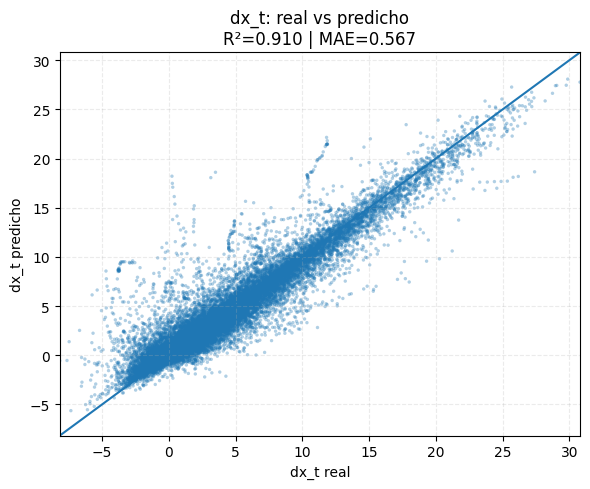

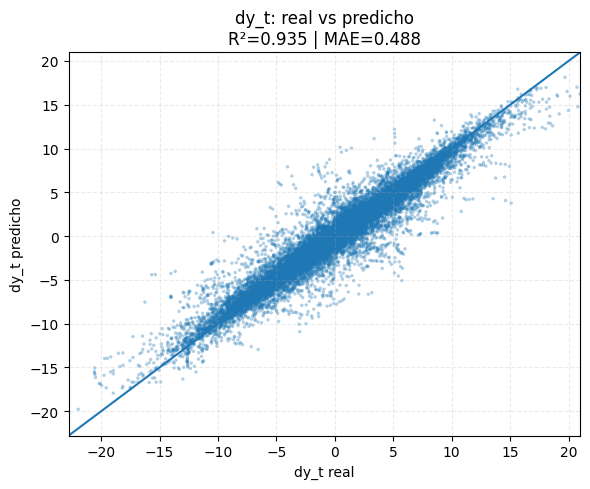

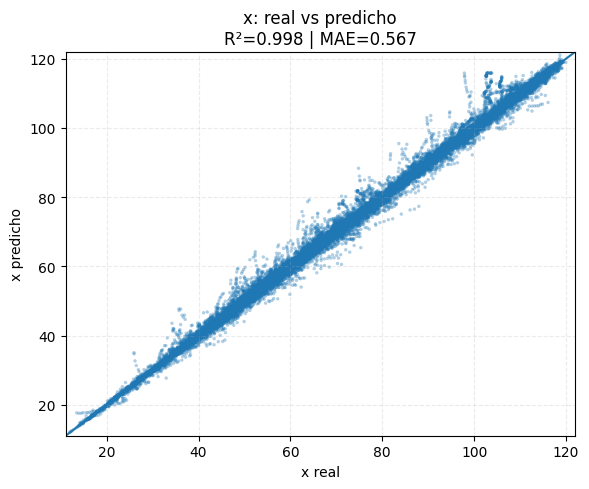

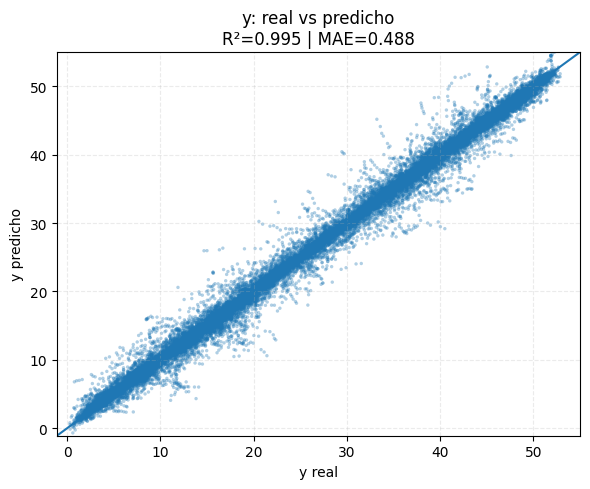

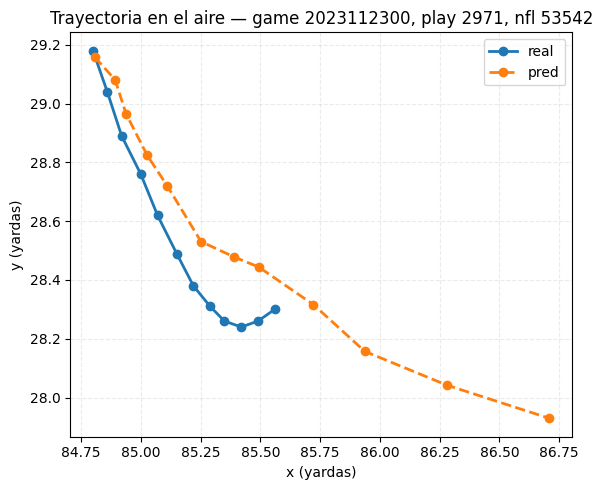

[B12.5] Gráficos generados: scatter dx/dy, scatter x/y (reconstruido) y trayectoria 2D de una jugada.


In [28]:
# === Bloque 12.5 · Gráficos reales vs predichos (eval_set) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Selección del modelo ganador (o el primero disponible si no existe best_model_name)
if 'best_model_name' in globals():
    model_name = best_model_name
else:
    model_name = list(best_pipes.keys())[0]
pipe = best_pipes[model_name]
print(f"[B12.5] Modelo para gráficos: {model_name}")

# Predicciones en eval_set
X_e = eval_set[NUM_COLS + CAT_COLS].copy()
y_e = eval_set[Y_COLS].values         # columnas [dx_t, dy_t]
yhat_e = pipe.predict(X_e)

# --- 1) Scatter dx_t y dy_t (verdad vs predicción) ---
def scatter_real_pred(y_true, y_pred, label, sample_max=50_000):
    # muestreo para no saturar el gráfico
    n = len(y_true)
    idx = np.arange(n)
    if n > sample_max:
        rng = np.random.RandomState(RANDOM_STATE)
        idx = rng.choice(idx, size=sample_max, replace=False)
    yt = y_true[idx]
    yp = y_pred[idx]

    # métricas rápidas
    from sklearn.metrics import r2_score, mean_absolute_error
    r2 = r2_score(yt, yp)
    mae = mean_absolute_error(yt, yp)

    plt.figure(figsize=(6,5))
    plt.scatter(yt, yp, s=6, alpha=0.35, edgecolors='none')
    lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
    plt.plot(lims, lims)   # línea y = x
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel(f"{label} real")
    plt.ylabel(f"{label} predicho")
    plt.title(f"{label}: real vs predicho\nR²={r2:.3f} | MAE={mae:.3f}")
    plt.grid(alpha=0.25, linestyle='--')
    plt.tight_layout()
    plt.show()

# dx_t
scatter_real_pred(y_e[:,0], yhat_e[:,0], label="dx_t")
# dy_t
scatter_real_pred(y_e[:,1], yhat_e[:,1], label="dy_t")

# --- 2) (Opcional) Reconstrucción de posiciones x,y y scatter ---
# x = x0 + dx_t; y = y0 + dy_t
x0 = eval_set["x0"].values
y0 = eval_set["y0"].values
x_true = x0 + y_e[:,0]
y_true = y0 + y_e[:,1]
x_pred = x0 + yhat_e[:,0]
y_pred = y0 + yhat_e[:,1]

def scatter_xy(xt, xp, label):
    plt.figure(figsize=(6,5))
    n = len(xt)
    idx = np.arange(n)
    if n > 50_000:
        rng = np.random.RandomState(RANDOM_STATE)
        idx = rng.choice(idx, size=50_000, replace=False)
    plt.scatter(xt[idx], xp[idx], s=6, alpha=0.35, edgecolors='none')
    lims = [min(xt.min(), xp.min()), max(xt.max(), xp.max())]
    plt.plot(lims, lims)
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel(f"{label} real"); plt.ylabel(f"{label} predicho")
    from sklearn.metrics import r2_score, mean_absolute_error
    r2 = r2_score(xt[idx], xp[idx]); mae = mean_absolute_error(xt[idx], xp[idx])
    plt.title(f"{label}: real vs predicho\nR²={r2:.3f} | MAE={mae:.3f}")
    plt.grid(alpha=0.25, linestyle='--')
    plt.tight_layout()
    plt.show()

# Posiciones
scatter_xy(x_true, x_pred, "x")
scatter_xy(y_true, y_pred, "y")

# --- 3) Trayectoria 2D para una jugada (real vs predicho) ---
# Toma una jugada aleatoria del eval_set y grafica su trayectoria (x,y) a través de los frames
rng = np.random.RandomState(RANDOM_STATE)
some_key = eval_set[["game_id","play_id","nfl_id"]].drop_duplicates().sample(1, random_state=RANDOM_STATE).iloc[0]
gk, pk, nk = int(some_key.game_id), int(some_key.play_id), int(some_key.nfl_id)

traj = eval_set[(eval_set.game_id==gk) & (eval_set.play_id==pk) & (eval_set.nfl_id==nk)].copy()
traj = traj.sort_values("frame_id")
Xe = traj[NUM_COLS + CAT_COLS]
ytrue = traj[["dx_t","dy_t"]].values
yhat  = pipe.predict(Xe)

x0_t = traj["x0"].values
y0_t = traj["y0"].values
x_true_t = x0_t + ytrue[:,0]
y_true_t = y0_t + ytrue[:,1]
x_pred_t = x0_t + yhat[:,0]
y_pred_t = y0_t + yhat[:,1]

plt.figure(figsize=(6,5))
plt.plot(x_true_t, y_true_t, marker='o', linewidth=2, label="real")
plt.plot(x_pred_t, y_pred_t, marker='o', linestyle='--', linewidth=2, label="pred")
plt.xlabel("x (yardas)"); plt.ylabel("y (yardas)")
plt.title(f"Trayectoria en el aire — game {gk}, play {pk}, nfl {nk}")
plt.legend()
plt.grid(alpha=0.25, linestyle='--')
plt.tight_layout()
plt.show()

print("[B12.5] Gráficos generados: scatter dx/dy, scatter x/y (reconstruido) y trayectoria 2D de una jugada.")


In [29]:
# === Bloque 12 · Comparación y ganador ===
cols_show = ["model","MAE_mean","MAE_std","MSE_mean","MSE_std","R2_mean","R2_std","MAPE_mean","MAPE_std","RMSE_vec_mean","RMSE_vec_std"]
show = eval_table[cols_show].copy()
show = show.sort_values(by=["MAE_mean","RMSE_vec_mean"], ascending=[True, True]).reset_index(drop=True)
print("[B12] Ranking por MAE (luego RMSE_vec) — media ± std")
display(show.style.format({
    "MAE_mean":"{:.4f}","MAE_std":"{:.4f}",
    "MSE_mean":"{:.4f}","MSE_std":"{:.4f}",
    "R2_mean":"{:.4f}","R2_std":"{:.4f}",
    "MAPE_mean":"{:.2f}","MAPE_std":"{:.2f}",
    "RMSE_vec_mean":"{:.4f}","RMSE_vec_std":"{:.4f}"
}))
best_model_name = show.iloc[0]["model"]
print(f"[B12] Ganador provisional: {best_model_name}")


[B12] Ranking por MAE (luego RMSE_vec) — media ± std


,model,MAE_mean,MAE_std,MSE_mean,MSE_std,R2_mean,R2_std,MAPE_mean,MAPE_std,RMSE_vec_mean,RMSE_vec_std
0,XGBRegressor,0.5169,0.0170,1.1161,0.1066,0.9251,0.0067,546.96,52.47,1.0565,0.0505
1,SGDRegressor,1.5473,0.0516,6.1303,1.1979,0.5874,0.0798,2096.07,155.44,2.4760,0.2419
2,ElasticNet,1.5806,0.0538,6.1907,1.4828,0.5835,0.0991,2436.26,177.13,2.4881,0.2980
3,Lasso,1.5807,0.0538,6.1918,1.4838,0.5835,0.0992,2437.39,177.21,2.4883,0.2981
4,LinearRegression,1.5811,0.0546,6.2295,1.5240,0.5809,0.1019,2442.25,178.08,2.4959,0.3053
5,Ridge,1.5812,0.0544,6.2205,1.5145,0.5815,0.1013,2445.42,178.52,2.4941,0.3036
6,BayesianRidge,1.5815,0.0546,6.2280,1.5227,0.5810,0.1018,2445.00,178.40,2.4956,0.3051


[B12] Ganador provisional: XGBRegressor


In [30]:
# === Bloque 12.8 · Tablas de métricas: Validación y Prueba (Eval) ===
import numpy as np
import pandas as pd
from IPython.display import display

# Usa la misma lista de features que el pipeline
try:
    FEATURES_FOR_MODEL
except NameError:
    FEATURES_FOR_MODEL = NUM_COLS + CAT_COLS

# Fallback por si compute_metrics no está en el entorno
def _compute_metrics_fallback(y_true, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # sobre los 2 targets concatenados
    # Para R2 multi-salida, lo calculamos como la media de R2 por columna
    r2  = np.mean([r2_score(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])])
    # MAPE seguro (evita división por 0): promedio de |e/y| sólo donde |y|>1e-6
    denom = np.abs(y_true)
    mask  = denom > 1e-6
    mape  = np.mean(np.abs((y_pred - y_true)[mask] / denom[mask])) * 100.0 if mask.any() else np.nan
    # RMSE vectorial aproximado desde MSE
    rmse = float(np.sqrt(mse))
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2, "MAPE": mape}

try:
    compute_metrics
except NameError:
    compute_metrics = _compute_metrics_fallback

def eval_split_table(df, split_name):
    rows = []
    X = df[FEATURES_FOR_MODEL].copy()
    y = df[Y_COLS].values
    for name, pipe in best_pipes.items():
        yhat = pipe.predict(X)
        m = compute_metrics(y, yhat)
        rows.append({
            "model": name,
            "MAE":  float(m["MAE"]),
            "MSE":  float(m["MSE"]),
            "RMSE": float(m.get("RMSE", np.sqrt(m["MSE"]))),
            "R2":   float(m["R2"]),
            "MAPE": float(m["MAPE"])
        })
    tab = pd.DataFrame(rows).sort_values(["MAE","RMSE"], ascending=[True,True]).reset_index(drop=True)
    print(f"[B12.8] Métricas en {split_name} (sin bootstrap) — ordenado por MAE")
    try:
        display(
            tab.style.format({"MAE":"{:.4f}","MSE":"{:.4f}","RMSE":"{:.4f}","R2":"{:.4f}","MAPE":"{:.2f}%"}).set_caption(split_name)
        )
    except Exception:
        print(tab.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    return tab

valid_table = eval_split_table(valid_set, "VALIDACIÓN (valid_set)")
eval_table_nb = eval_split_table(eval_set, "PRUEBA / HOLD-OUT (eval_set)")

# opcional: guardar a disco
valid_table.to_csv("/kaggle/working/metrics_valid.csv", index=False)
eval_table_nb.to_csv("/kaggle/working/metrics_eval.csv", index=False)
print("[B12.8] Guardado: metrics_valid.csv y metrics_eval.csv en /kaggle/working/")


[B12.8] Métricas en VALIDACIÓN (valid_set) (sin bootstrap) — ordenado por MAE


,model,MAE,MSE,RMSE,R2,MAPE
0,XGBRegressor,0.5002,1.0030,1.0015,0.9311,566.80%
1,SGDRegressor,1.4595,4.6930,2.1663,0.6722,2084.15%
2,LinearRegression,1.4900,4.5423,2.1313,0.6825,2374.49%
3,Ridge,1.4901,4.5413,2.1310,0.6826,2376.04%
4,BayesianRidge,1.4903,4.5417,2.1311,0.6826,2376.48%
5,ElasticNet,1.4904,4.5421,2.1312,0.6826,2377.45%
6,Lasso,1.4905,4.5420,2.1312,0.6826,2377.75%


[B12.8] Métricas en PRUEBA / HOLD-OUT (eval_set) (sin bootstrap) — ordenado por MAE


,model,MAE,MSE,RMSE,R2,MAPE
0,XGBRegressor,0.5272,1.1830,1.0877,0.9215,538.79%
1,SGDRegressor,1.5749,6.6686,2.5824,0.5574,2085.14%
2,ElasticNet,1.6089,6.8322,2.6138,0.5469,2427.18%
3,Lasso,1.6090,6.8336,2.6141,0.5468,2428.47%
4,LinearRegression,1.6096,6.8867,2.6243,0.5433,2435.65%
5,Ridge,1.6097,6.8741,2.6219,0.5441,2438.26%
6,BayesianRidge,1.6100,6.8847,2.6239,0.5434,2438.11%


[B12.8] Guardado: metrics_valid.csv y metrics_eval.csv en /kaggle/working/


### Bloque 13 · Guardar pipeline ganador

In [31]:
# # === Bloque 13 · Guardar pipeline ganador ===
# import joblib, os
# os.makedirs("models", exist_ok=True)

# best_name = best_model_name
# best_pipe = final_pipes[best_name]
# job_path = f"models/{best_name}_pipeline.pkl"
# joblib.dump(best_pipe, job_path)
# print(f"[B13] Guardado: {job_path}")

# === Bloque 13·all · Guardar TODOS los pipelines disponibles ===
import os, time, joblib, pandas as pd
os.makedirs("models", exist_ok=True)

manifest = []
for name, pipe in final_pipes.items():   # final_pipes: {"Ridge": pipe, "Lasso": pipe, ...}
    path = f"models/{name}_pipeline.pkl"
    joblib.dump(pipe, path)
    manifest.append({"model": name, "file": path, "saved_at": time.strftime("%Y-%m-%d %H:%M:%S")})

pd.DataFrame(manifest).to_csv("models/index_models_final.csv", index=False)
print(f"[B13·all] Guardados {len(manifest)} modelos en /models")



[B13·all] Guardados 7 modelos en /models


In [32]:
!zip -r -q /kaggle/working/tuning_artifacts.zip /kaggle/working/tuning_artifacts
!zip -r -q /kaggle/working/models.zip /kaggle/working/models


In [33]:
!zip -r -q /kaggle/working/resultados.zip /kaggle/working